In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
import sys
from os.path import join
import math
import matplotlib.pyplot as plt

sys.path.insert(0, '/'.join(sys.path[0].split('/')[:-1] + ['scripts']))
from operations import *
from sequential_model import *

In [3]:
#export
class Dataset():
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data
    
    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, i):
        return self.x_data[i], self.y_data[i]

In [4]:
#export
class Sampler():
    def __init__(self, size, batch_size, shuffle=True):
        self.size = size
        self.batch_size = batch_size
        self.shuffle = shuffle
    
    def __iter__(self):
        self.idxs = torch.randperm(self.size) if self.shuffle else torch.arange(self.size)
        for i in range(0, self.size, self.batch_size):
            yield self.idxs[i: i+self.batch_size]
            
def collate(batch):
    x_batch, y_batch = zip(*batch)
    return torch.stack(x_batch), torch.stack(y_batch)

In [5]:
class DataLoader():
    def __init__(self, dataset, sampler, collate_fn=collate):
        self.dataset = dataset
        self.sampler = sampler
        self.collate_fn = collate_fn
        
    def __iter__(self):
        for idxs in self.sampler:
            yield self.collate_fn([self.dataset[i] for i in idxs])

In [6]:
#export
def compute_accuracy(pre, tar):
    return (torch.argmax(pre, dim=1) == tar).float().mean()

In [7]:
#export
class Optimizer():
    def __init__(self, parameters, learning_rate):
        self.parameters = parameters
        self.learning_rate = learning_rate
    
    def step(self):
        for parameter in self.parameters:
            parameter.step(self.learning_rate)
    
    def zero_grad(self):
        for parameter in self.parameters:
            parameter.zero_grad()

In [8]:
#export
def fit(num_epochs, model, optimizer, loss_fn, train_data, valid_data):
    accuracies = []
    losses = []
    
    for epoch in range(1, num_epochs+1):
        for x_batch, y_batch in train_data:
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            
            loss_fn.backward()
            model.backward()
            
            optimizer.step()
            optimizer.zero_grad()
            
        count = accuracy = loss = 0
        for x_batch, y_batch in valid_data:
            pred = model(x_batch)
            accuracy += compute_accuracy(pred, y_batch)
            loss += loss_fn(pred, y_batch)
            count += 1
        accuracy /= count
        loss /= count
        
        accuracies.append(accuracy)
        losses.append(loss)
        print(f'Epoch {epoch}    Accuracy {round(accuracy.item(), 3)}    Loss {round(loss.item(), 3)}')
    
    return accuracies, losses

In [9]:
x_train, y_train, x_valid, y_valid = get_mnist_data()

In [10]:
num_hidden = 50
num_train, in_dim = x_train.shape
num_valid = len(x_valid)
out_dim = int(y_train.max() + 1)
batch_size = 64
learning_rate = 0.1

print(num_train, num_valid, in_dim, num_hidden, out_dim)

50000 10000 784 50 10


In [11]:
train_ds = Dataset(x_train, y_train)
valid_ds = Dataset(x_valid, y_valid)
train_dl = DataLoader(train_ds, Sampler(len(train_ds), batch_size, True))
valid_dl = DataLoader(valid_ds, Sampler(len(valid_ds), batch_size*2, False)) # twice batch size (no backprop)

In [12]:
from torch import nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]
        
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

model = Model(in_dim, num_hidden, out_dim)
pred = model(x_train)

loss1 = nll_loss(log_softmax(pred), y_train)
loss2 = cross_entropy(pred, y_train)
loss3 = F.nll_loss(F.log_softmax(pred, -1), y_train)
loss4 = F.cross_entropy(pred, y_train)

test_near(loss1, loss2)
test_near(loss2, loss3)
test_near(loss3, loss4)

In [13]:
model = Sequential(Linear(in_dim, num_hidden), ReLU(), Linear(num_hidden, out_dim, end=True))
loss_fn = CrossEntropy()
optimizer = Optimizer(list(model.parameters()), learning_rate)
num_epochs = 20

accuracies, losses = fit(num_epochs, model, optimizer, loss_fn, train_dl, valid_dl)

Epoch 1    Accuracy 0.93    Loss 0.249
Epoch 2    Accuracy 0.945    Loss 0.196
Epoch 3    Accuracy 0.957    Loss 0.159
Epoch 4    Accuracy 0.955    Loss 0.157
Epoch 5    Accuracy 0.958    Loss 0.156
Epoch 6    Accuracy 0.964    Loss 0.13
Epoch 7    Accuracy 0.968    Loss 0.114
Epoch 8    Accuracy 0.969    Loss 0.112
Epoch 9    Accuracy 0.969    Loss 0.111
Epoch 10    Accuracy 0.97    Loss 0.108
Epoch 11    Accuracy 0.971    Loss 0.103
Epoch 12    Accuracy 0.972    Loss 0.102
Epoch 13    Accuracy 0.971    Loss 0.102
Epoch 14    Accuracy 0.972    Loss 0.098
Epoch 15    Accuracy 0.971    Loss 0.099
Epoch 16    Accuracy 0.972    Loss 0.098
Epoch 17    Accuracy 0.974    Loss 0.097
Epoch 18    Accuracy 0.973    Loss 0.098
Epoch 19    Accuracy 0.973    Loss 0.098
Epoch 20    Accuracy 0.972    Loss 0.097


In [14]:
#export
def plot(data, label):
    plt.plot(list(range(1,len(data)+1)), data)
    plt.xlabel('epoch')
    plt.ylabel(label)
    plt.xticks(list(range(1,len(data)+1)))
    plt.show()

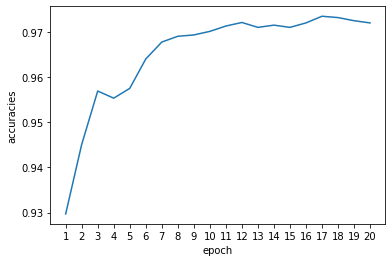

In [15]:
plot(accuracies, 'accuracies')

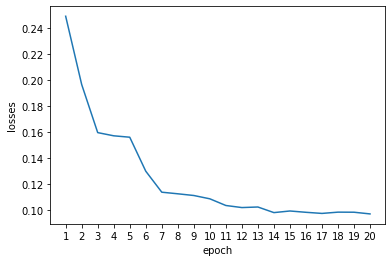

In [16]:
plot(losses, 'losses')